In [1]:
from timeit import timeit
from IPython.display import display
import matplotlib
# matplotlib.use("pgf")
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap
import seaborn as sns

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

2022-03-14 15:54:38.912063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hampus/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-14 15:54:38.912089: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-14 15:54:39.945257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 15:54:39.945588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hampus/.local/lib/python3.8/site-packages/cv2/../../lib

,t,ID,DLC,d0,d1,d2,d3,d4,d5,d6,d7,dt,dt_ID,dataset,type,Label
0,0.000000,608,8,21,30,30,48,0,143,123,44,0.000444,0.009978,Survival,none,0
1,0.000232,672,8,64,0,118,29,204,4,227,0,0.000232,0.009977,Survival,none,0
2,0.000480,704,8,20,0,0,0,0,0,0,0,0.000248,0.009981,Survival,none,0
3,0.000714,809,8,12,185,127,20,17,32,0,20,0.000234,0.009978,Survival,none,0
4,0.000955,1349,8,216,0,0,140,0,0,0,0,0.000241,0.009978,Survival,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735835,59.573580,562,8,0,0,0,8,0,0,0,0,0.000248,0.020620,Survival,none,0
1735836,59.573815,398,8,0,0,0,105,166,154,6,154,0.000235,0.013305,Survival,none,0
1735837,59.574057,401,8,6,154,6,170,6,154,0,0,0.000242,0.013092,Survival,none,0
1735838,59.574492,199,4,0,7,2,32,0,0,0,0,0.000435,0.012329,Survival,none,0


In [3]:
df = df.loc[df["type"] != "masq"]

In [4]:
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "ID", "DLC", "t"], inplace=True, errors="ignore")

display(df)

,dt,dt_ID,dataset,type,Label
0,0.000444,0.009978,Survival,none,0
1,0.000232,0.009977,Survival,none,0
2,0.000248,0.009981,Survival,none,0
3,0.000234,0.009978,Survival,none,0
4,0.000241,0.009978,Survival,none,0
...,...,...,...,...,...
1735835,0.000248,0.020620,Survival,none,0
1735836,0.000235,0.013305,Survival,none,0
1735837,0.000242,0.013092,Survival,none,0
1735838,0.000435,0.012329,Survival,none,0


In [5]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# df.loc[:, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "Label")] = StandardScaler(copy=True).fit_transform(
#     df.loc[:, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "Label")]
# )

# display(df)

In [6]:
X_train = df.drop(columns="type")
y_train = df["type"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)

# Use feature "Label" as classification label
d_temp: pd.DataFrame = pd.concat([X_train, y_train], axis="columns")
X_train, y_train = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp: pd.DataFrame = pd.concat([X_test, y_test], axis="columns")
X_test, y_test = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp = None # Release memory

In [7]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		128320		465758
Attack		128320		54994


In [8]:
# X_test = X_test.loc[(X_test["type"] == "fuzz") | (X_test["type"] == "none")]
# y_test = y_test.loc[X_test.index]

In [9]:
X_train.drop(columns=["type", "dataset"], inplace=True)
X_test.drop(columns=["type", "dataset"], inplace=True)

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2").fit(X_train, y_train)

Training F1: 0.9917 (+/- 0.0007)
Testing F1:  0.9924(+/- 0.0000)
Kappa score:  0.9600(+/- 0.0000)


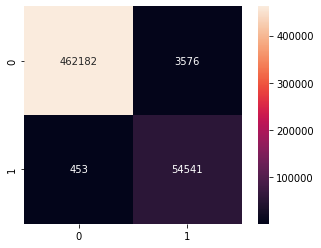

In [11]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test)

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

cm = confusion_matrix(y_test, pred)
annots = pd.DataFrame(confusion_matrix(y_test, pred)).applymap(str)
sns.heatmap(cm, annot=annots, fmt="s", square=True)
plt.show()

# Total attack: 465758,     Total normal: 54994
# All below are random_seed=0
# Not under-sampled:        FN=387, FP=286
# Under-sampled:            FN=119, FP=1149
# Under-sampled (type):     FN=176, FP=1363

# Scaled and Under-sampled: FN=116, FP=1214

# RF: 20 trees, log2

# Survival

# Data: Scaled and Under-sampled
# FN=106, FP=885 (run_diff)
# FN=109, FP=775 (run_diff, run_diff_ID)
# FN=130, FP=896 (run_diff, run_diff_ID both subtract zero_runs from one_runs)
# Fn=103, FP=487 (run_diff, run_diff_ID both have one_runs/(zero_runs+1), +1 to avoid division by 0)
# Data: Scaled (Standard) and Under-sampled
# Fn=100, FP=477 (run_diff, run_diff_ID both have one_runs/(zero_runs+1), +1 to avoid division by 0)
# Data: Under-sampled (not Scaled)
# Fn=100, FP=475 (run_diff, run_diff_ID both have one_runs/(zero_runs+1), +1 to avoid division by 0)

# Data: Under-sampled (not Scaled), run_diff and run_diff_ID (one_runs/(zero_runs+1))
# Fabrication:  FNR=0.001697433     FPR=0.001019843
# Flooding:     FNR=0               FPR=0.001019843
# Fuzzing:      FNR=0.004392616     FPR=0.001019843

# ORNL/ROAD (without Masquerade)

# Data: Under-sampled, Scaled (Standard), run_diff and run_diff_ID (one_runs/(zero_runs+1))
# All attacks:  FNR=0               FPR=0.000258018
# Data: Under-sampled (not Scaled), run_diff and run_diff_ID (one_runs/(zero_runs+1))
# All attacks:  FNR=0               FPR=0.000252816